# On The Expansion of the Prison Population in the United States Over The Last Century

* This notebook uses data visulization to explore the expansion of the prison populaltion in the US over the last century and touches on some major contributing factors
* Incarcerated rates have increased starting in the 1980s, likely due to 
  * Financial incentives of state and federal contracts.
  * Bail bonds companies benefiting from pre-trial policies
  * Judicial Discretion regarding bail and other sentence attributes
* Monetary policies like bail play a crucial role in the increase of incarcerated people. 
* Despite the accountability suggested by bail, its actually seems more like a system movitvated by profit rather than the pursuit of justice. 
* By disproportionally impacting the poor, fixed monetary penalties have generated concerns about the fairness of the current criminal justice system. 
* Their use has been largely ineffective at reducing fiscal pressures on local budgets and reducing risk to public safety , since it places large burdens on those least able to pay, and resultsed in jursitictions detaining the poorest, rather than ommst dangerous, defendants. 

In [37]:
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.use("TkAgg")  # Need to uninstall and reinstall matplotlib in order for this to be default
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
sns.set(font_scale=2)
import os
import numpy as np
from itertools import cycle, islice

### Preprocess data from Census Bureau 

Normalize incarceration population totals with national population totals 

In [38]:
def format_population_estimate_data(data_dir="./data", save=False):
    yearly_population_total_estimate = pd.DataFrame(columns=["Year", "Population"])
    dfs = [x for x in os.listdir(data_dir)]

    for df in dfs:
        # Process pe (population estimate) 'vintage' data sets 1920s-1970s
        if 'pe' in df and '~lock' not in df:
            start_year = int(df[-9:-5])
            for year in range(start_year, start_year + 9):
                if year <= 1959:
                    df_year = pd.read_excel("./data/" + df, sheet_name=str(year),
                                            skiprows=5)  # 'Includes alaska and hawaii' extra line line is in sheets before 1960
                else:
                    df_year = pd.read_excel("./data/" + df, sheet_name=str(year), skiprows=4)
                total_pop = df_year['Total'].loc[1]
                yearly_population_total_estimate = yearly_population_total_estimate.append(
                    {"Year": str(year), "Population": total_pop}, ignore_index=True)

    # Process 1980-2000, 2000-2010, 2010-2020 separately since they all have different formats :(
    # 1980-2000
    # df = pd.read_fwf(data_dir+"/1980s.txt")
    df = pd.read_fwf("./data/1980-2000.txt", names=['ResidentPop', 'ResPop_AF',
                                                    'CivilianPop', 'CivilianPop_NI'])
    df_new = df[df.index == 'November 1']
    df_new.sort_values(by='ResidentPop', inplace=True)
    df_new['Year'] = list(range(1980, 2001))
    df_new.ResidentPop = df_new.ResidentPop.apply(lambda z: z + ',000')
    df_new['Population'] = df_new.ResidentPop.apply(lambda z: int(''.join(z.split(','))))
    df_new.Year = df_new.Year.apply(lambda z: int(z))
    yearly_population_total_estimate = yearly_population_total_estimate.append(df_new[['Year', 'Population']])
    yearly_population_total_estimate.Year = yearly_population_total_estimate.Year.apply(lambda z: int(z))

    yearly_population_total_estimate.reset_index(inplace=True, drop=True)

    # Add 1979 as an average of 1978 and 1980 since this year was somehow not in there
    yearly_population_total_estimate = yearly_population_total_estimate.append({'Year': 1979, 'Population': (
                                                                                yearly_population_total_estimate[
                                                                                    yearly_population_total_estimate.Year == 1980].Population.values[0] +
                                                                                yearly_population_total_estimate[
                                                                                    yearly_population_total_estimate.Year == 1978].Population.values[0]) / 2},
                                                                                ignore_index=True)

    df2k2k10 = pd.read_csv(data_dir + "/2000-2010.csv")
    for yp in df2k2k10[(df2k2k10.AGE == 999) & (df2k2k10.MONTH == 7)][['YEAR', 'TOT_POP']].iterrows():
        yearly_population_total_estimate = yearly_population_total_estimate.append({'Year': yp[1].YEAR,
                                                                                    'Population': yp[1].TOT_POP},
                                                                                   ignore_index=True)


    # 2010 - 2020
    df2010 = pd.read_excel(data_dir + "/na-est2019-01.xlsx")
    df2010.reset_index(inplace=True, drop=True)
    df2010.columns = list(df2010.iloc[1].values)
    df1 = df2010[df2010['Year and Month'] == '.April 1']
    df1['Year'] = list(range(2010, 2021))
    for x in df1.iterrows():
        yearly_population_total_estimate = yearly_population_total_estimate.append({'Year': x[1].Year,
                                                                                    'Population': x[1]['Resident Population']},
                                                                                   ignore_index=True)


    yearly_population_total_estimate.sort_values(by='Year', inplace=True)
    yearly_population_total_estimate = yearly_population_total_estimate.astype(int)
    if save:
        yearly_population_total_estimate.to_csv(data_dir+"/yearly_population_estimates_1925_2020.csv", index=False)
    return yearly_population_total_estimate

In [39]:
prison_data = pd.read_excel('incarceration_counts_and_rates_by_type_over_time2.xlsx',
                   index_col=0,
                   header=None)
prison_data = prison_data.transpose()
prison_data.columns = ['Year', 'State prisons', 'Federal prisons']
prison_data.reset_index(drop=True,inplace=True)
prison_data.index = prison_data.Year
population = format_population_estimate_data()

prison_data.reset_index(drop=True, inplace=True) # Drop 'Year' index because too ambiguous for merge
data = pd.merge(prison_data, population, on='Year')

data['State_Prison_Percentage'] = data['State prisons']/data['Population']
data['Fed_Prison_Percentage'] = data['Federal prisons']/data['Population']
data['Prison_Percentage'] = (data['State prisons'] + data['Federal prisons'])/data['Population']

data['Prison_Count'] = data['State prisons'] + data['Federal prisons']

C:\Users\Celeste manughian-pe\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Celeste manughian-pe\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Celeste manughian-pe\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

### Percentage of people in US prison over the centruy


In [40]:
def colors_from_values(values, palette_name, reverse_pal=False, pal_as_obj=False):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    if not pal_as_obj:
        palette = sns.color_palette(palette_name, len(values))
    else:
        palette = palette_name # sns.cubehelix_palette(8)
    if not reverse_pal:
        return np.array(palette).take(indices, axis=0)
    else:
        return np.array(palette[::-1]).take(indices, axis=0)

In [41]:
colorlist = ['#9FACA3','#C27958', '#437470', '#F3937D', '#FEEAB8', '#566C5D', '#36504D','#9B7E80', 
             '#432128', '#883525', 
             ]

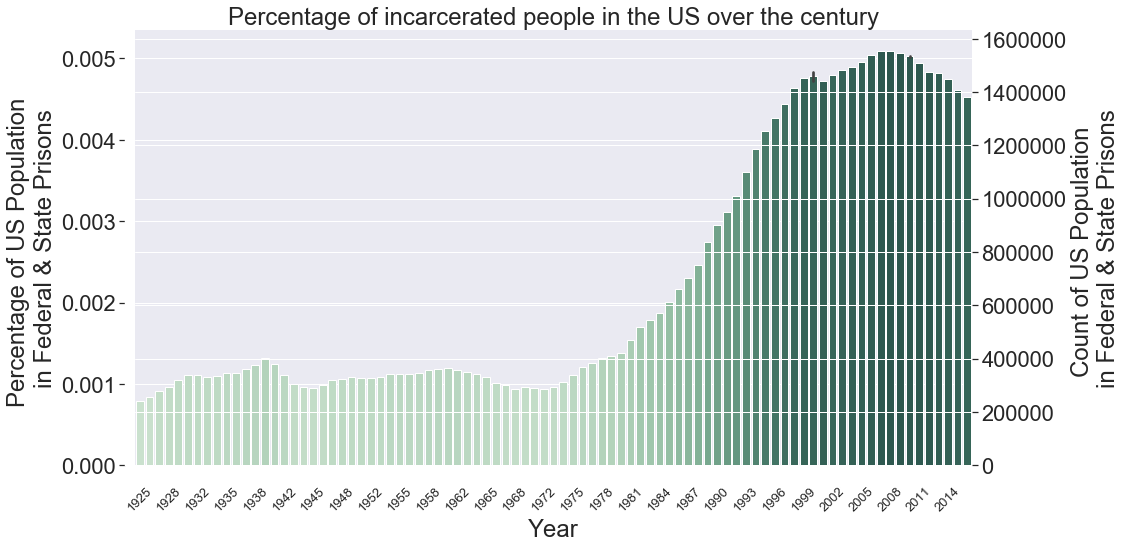

In [42]:
# Q1: Is percentage of people in prison vs the total population increasing over time?
# Start exploring
# Percentages over time
sns.set_style("white")
pal1=colors_from_values(data.Prison_Percentage, sns.cubehelix_palette(len(data)))
pal2 = colors_from_values(data.Prison_Percentage, "Blues_d")
pal3 =  colors_from_values(data.Prison_Percentage, "ch:2.5,-.2,dark=.3")
pal4 = colors_from_values(data.Prison_Percentage, colorlist)
pal1 = pal3

sns.set(font_scale=2)
plt.figure(figsize=(15, 8))
ax = plt.gca()
b1 = sns.barplot(data=data, x='Year', y='Prison_Percentage', palette=pal1)
sns.despine(offset=10, trim=True);
plt.ylabel("Percentage of US Population \nin Federal & State Prisons")
plt.xticks(rotation=90)
ax2 = plt.twinx()
sns.barplot(data=data, x="Year", y="Prison_Count", ax=ax2, alpha=0) #, alpha=.4, palette=pal2) # TODO: help with alpha here
sns.despine(offset=10, trim=True);
plt.ylabel("Count of US Population \nin Federal & State Prisons")
# plt.xticks(rotation=90)
plt.title("Percentage of incarcerated people in the US over the century")
ax.xaxis.set_tick_params(labelsize=13)
plt.savefig("Percentage_in_prison.png")
every_other_label = [x if i%3 == 0  else '' for i,x in enumerate(b1.get_xticklabels()) ]
_ = b1.set_xticklabels(every_other_label, rotation=45)

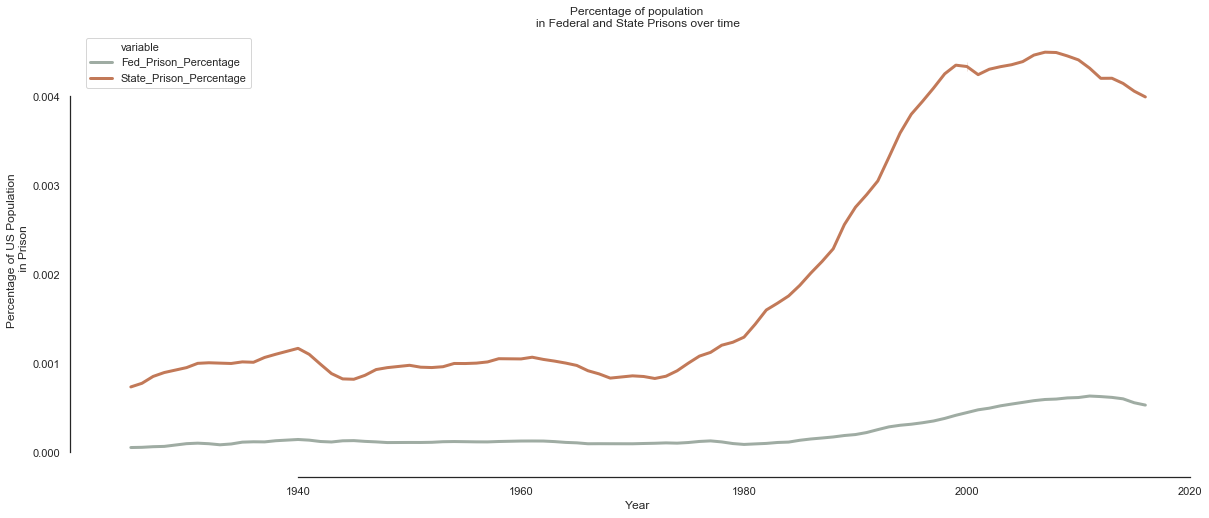

In [43]:
sns.set(rc={"lines.linewidth": 3})
sns.set_style("white")
plt.figure(figsize=(20,8))
data_melted = data.melt(id_vars=['Year'], value_vars=['Fed_Prison_Percentage', 'State_Prison_Percentage'])
sns.lineplot(data=data_melted, x='Year', y='value', hue='variable', sizes=(15), palette=pal4)
sns.despine(offset=10, trim=True);
_ = plt.title("Percentage of population \nin Federal and State Prisons over time")
plt.ylabel("Percentage of US Population\n in Prison")
plt.show()


### What happened in 1980s?

In [44]:
cs = pd.read_csv("./data/conviction_status_1983-2013.txt", sep='\t')
cs.columns = [c.rstrip() for c in cs.columns]  # take out that whitespace

cs_melted = cs.melt(value_vars=cs.columns[1:], id_vars=['Status'])
cs_melted.columns = ['Status', 'Year', 'Num_Prisoners']
cs_melted.Year = cs_melted.Year.astype(int)
# take off the whitespace and remove the commas so we can convert to number
cs_melted.Num_Prisoners= cs_melted.Num_Prisoners.apply(lambda z: ''.join(z.split(',')).rstrip()) 
cs_melted.Num_Prisoners = cs_melted.Num_Prisoners.astype(int)

Jail growth has occurred predominately — and in the last 15 years, almost entirely — in the number of people being detained pre-trial


C:\Users\Celeste manughian-pe\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 61530 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Celeste manughian-pe\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 61530 missing from current font.
  font.set_text(s, 0, flags=flags)


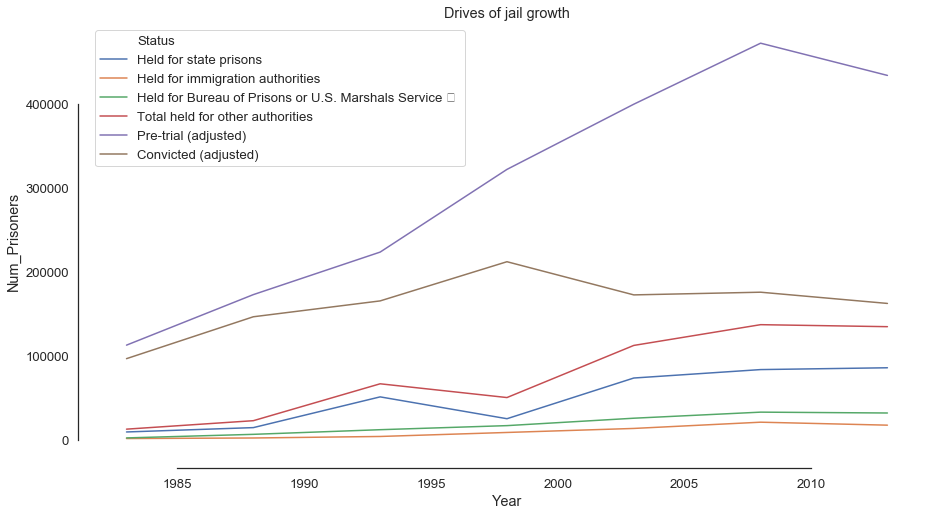

In [45]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.2)
sns.set_style("white")
# d1 = cs_melted[~cs_melted.Status.str.contains('unadjusted')]
# _ = sns.lineplot(data=cs_melted[~cs_melted.Status.str.contains('unadjusted')], x='Year', y='Num_Prisoners', hue='Status')
# _ = sns.lineplot(data=cs_melted[~cs_melted.Status.str.contains('unadjusted')], x='Year', y='Num_Prisoners', hue='Status', opacity=.4)
sns.lineplot(data=cs_melted[~cs_melted.Status.str.contains('unadjusted')], x='Year', y='Num_Prisoners', hue='Status')
sns.despine(offset=10, trim=True);
# _ = plt.ylabel("Number of Prisoners")
plt.title("Drives of jail growth")
print("Jail growth has occurred predominately — and in the last 15 years, almost entirely \
— in the number of people being detained pre-trial")

In [46]:
cs_melted.head()

,Status,Year,Num_Prisoners
0,Pre-trial (unadjusted),1983,113984
1,Convicted (unadjusted),1983,107660
2,Held for state prisons,1983,9134
3,Held for immigration authorities,1983,1304
4,Held for Bureau of Prisons or U.S. Marshals Se...,1983,2044


Jail growth has occurred predominately — and in the last 15 years, almost entirely — in the number of people being detained pre-trial


C:\Users\Celeste manughian-pe\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 61530 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Celeste manughian-pe\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 61530 missing from current font.
  font.set_text(s, 0, flags=flags)


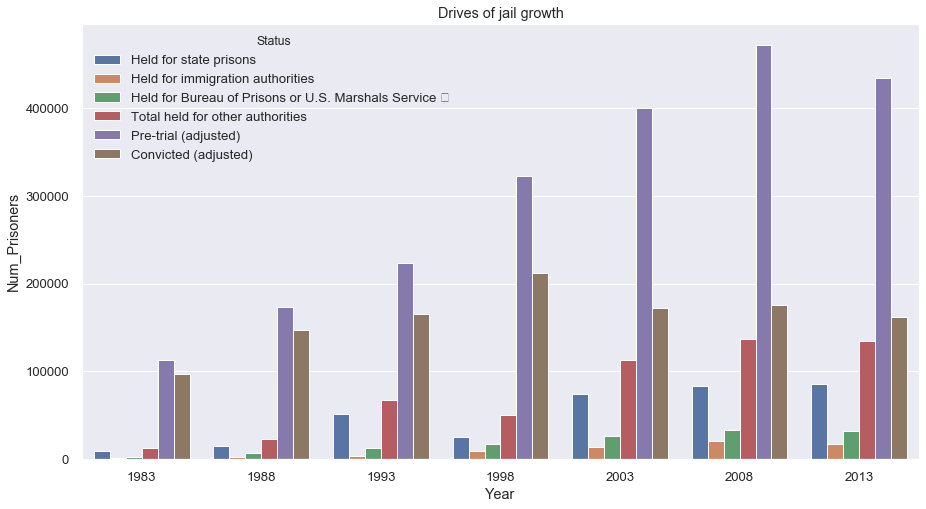

In [55]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.2)
data = cs_melted[~cs_melted.Status.str.contains('unadjusted')]
# my_colors = list(islice(cycle(colorlist), None, len(np.unique(data.Status))))
# _ = sns.lineplot(data=cs_melted[~cs_melted.Status.str.contains('unadjusted')], x='Year', y='Num_Prisoners', hue='Status')
# _ = sns.lineplot(data=cs_melted[~cs_melted.Status.str.contains('unadjusted')], x='Year', y='Num_Prisoners', hue='Status', opacity=.4)
sns.barplot(data=cs_melted[~cs_melted.Status.str.contains('unadjusted')], x='Year', y='Num_Prisoners', 
            hue='Status')#, colors=my_colors)
# _ = plt.ylabel("Number of Prisoners")
plt.title("Drives of jail growth")
print("Jail growth has occurred predominately — and in the last 15 years, almost entirely \
— in the number of people being detained pre-trial")

In [49]:
pivot_df = data.pivot(index='Year', columns='Status', values='Num_Prisoners')

Jail growth has occurred predominately — and in the last 15 years, almost entirely — in the number of people being detained pre-trial


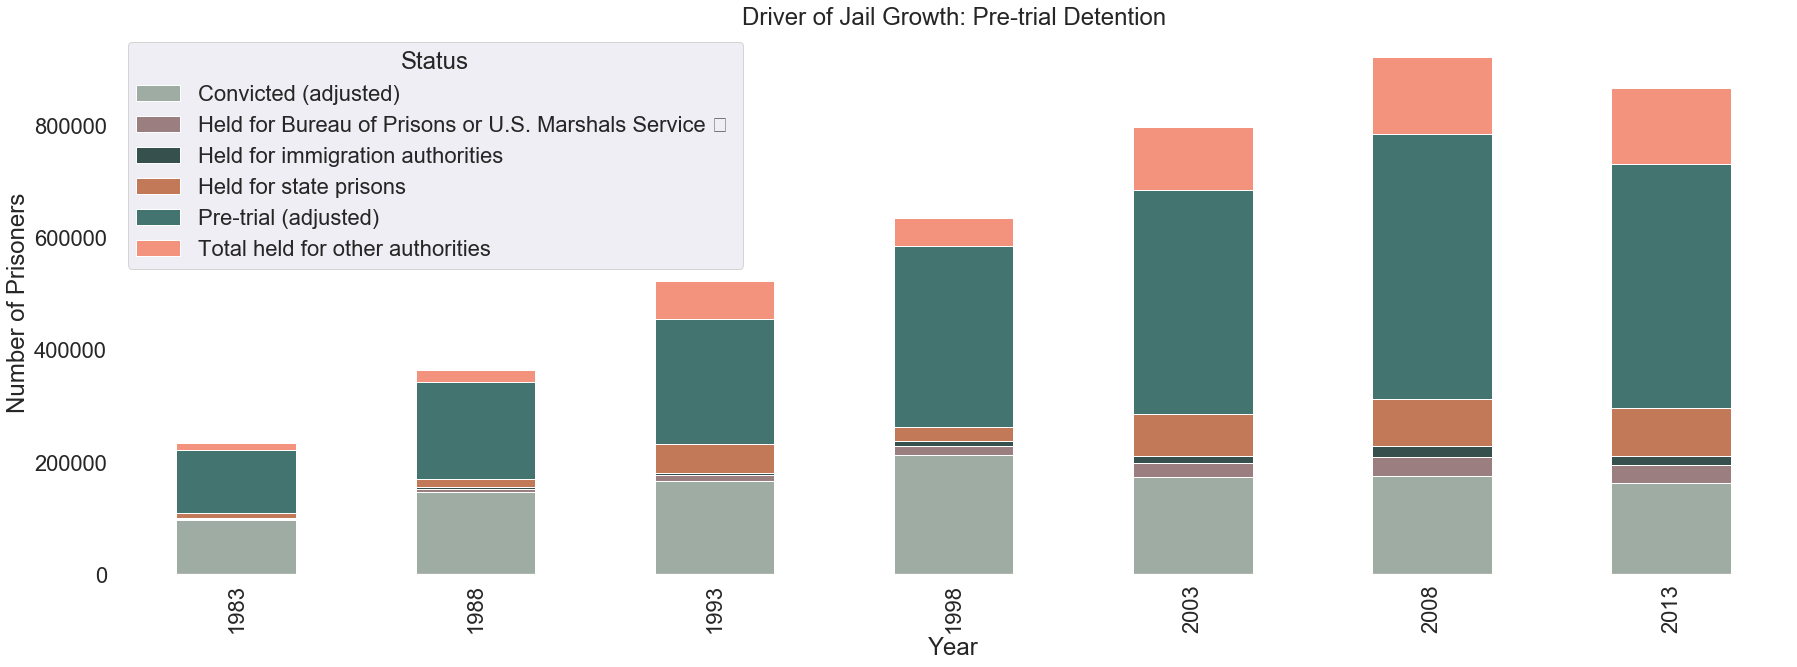

In [50]:
colorlist = ['#9FACA3','#9B7E80','#36504D','#C27958', '#437470', '#F3937D',  '#566C5D',  
            
             ] # '#FEEAB8', '#432128', '#883525',
sns.set(font_scale=2)
my_colors = list(islice(cycle(colorlist), None, len(np.unique(data.Status))))
x = pivot_df.plot(kind='bar', stacked=True, figsize=(30,10), color=my_colors)
_ = plt.ylabel("Number of Prisoners")
plt.title("Driver of Jail Growth: Pre-trial Detention")
print("Jail growth has occurred predominately — and in the last 15 years, almost entirely \
— in the number of people being detained pre-trial")
x.set_facecolor("white")

Text(0.5, 0, 'Year\n\nSource: https://www.bjs.gov/index.cfm?ty=pbdetail&iid=4845 ')

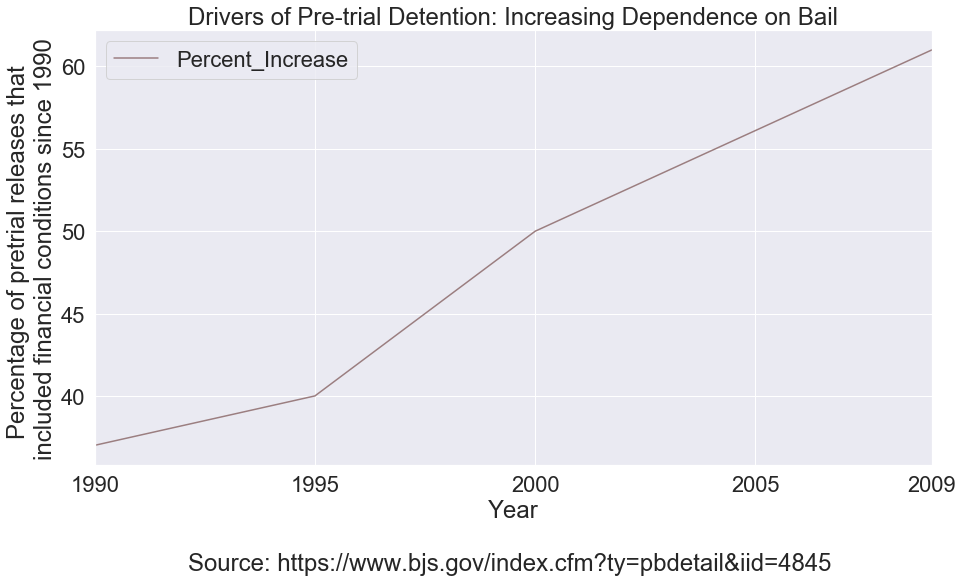

In [51]:

# https://www.bjs.gov/index.cfm?ty=pbdetail&iid=4845 Source
percentage_of_bail_increase = pd.DataFrame({"Year": [1990, 1995, 2000, 2009], "Percent_Increase": [37, 40, 50, 61]})
percentage_of_bail_increase.plot(x='Year', y='Percent_Increase', figsize=(15,8), color=my_colors[1])
_ = plt.title("Drivers of Pre-trial Detention: Increasing Dependence on Bail")
plt.xticks([1990, 1995, 2000, 2005, 2009])
_ = plt.ylabel("Percentage of pretrial releases that \nincluded financial conditions since 1990")
plt.xlabel('''Year

Source: https://www.bjs.gov/index.cfm?ty=pbdetail&iid=4845 ''')

C:\Users\Celeste manughian-pe\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


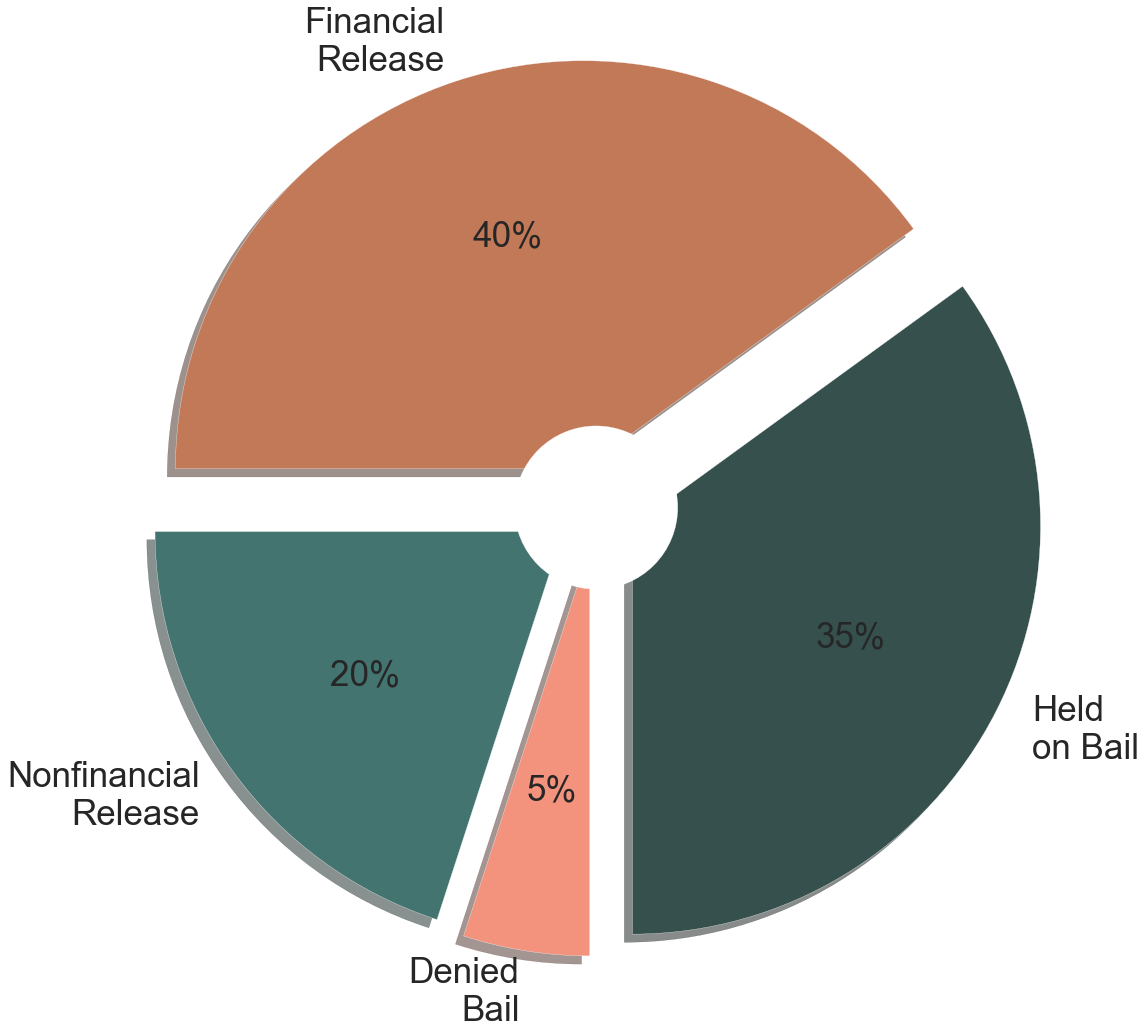

In [54]:
# plt.rcParams.update({'font.size': 30})
plt.style.use("seaborn")
sizes = [35,40,20,5]
labels = ['Held\non Bail', 'Financial\nRelease', 'Nonfinancial\nRelease', 'Denied\nBail']
pie = pd.DataFrame(sizes)
pie.index = labels

fig1, ax1 = plt.subplots(figsize=(16,15))
flavor_pie = ax1.pie(pie,labels=labels, autopct='%.0f%%', shadow=True, colors=my_colors[-4:], 
                     explode=[.1,.1,.1,.1], startangle= -90, textprops={'fontsize': 35})

centre_circle = plt.Circle((0,0), 0.20, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.show()

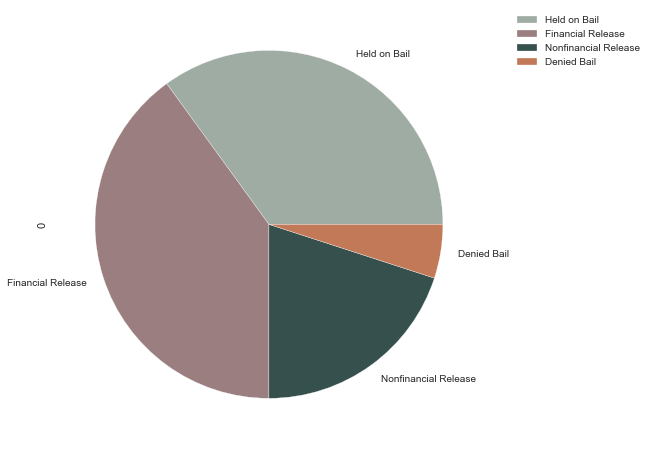

In [56]:
# matplotlib.rcParams['font.size'] = 20
plt.rcParams.update({'font.size': 30})
plt.style.use("seaborn")
sizes = [35,40,20,5]
labels = ['Held on Bail', 'Financial Release', 'Nonfinancial Release', 'Denied Bail']
pie = pd.DataFrame(sizes)
pie.index = labels
# plt.rcParams["font.size"] = "50"
p = pie.plot.pie(y=0, figsize=(20,8), colors=colorlist)
p.legend(bbox_to_anchor=(1.05, 1))

## References and Notes

Palettes: 

https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette

Fines Feeds And Bail 

https://obamawhitehouse.archives.gov/sites/default/files/page/files/1215_cea_fine_fee_bail_issue_brief.pdf

Found at

https://www.bjs.gov/index.cfm?ty=pbdetail&iid=4845

Other Investigation Notes

* More unconvicted people in prison - show conviected vs not convicted over time (policy changes in 1983 that make it more likely for people to be detained prior to trial ) (why would people benefit from more unconvicted people in prison?)
https://ideas.ted.com/how-the-bail-system-in-the-us-became-such-a-mess-and-how-it-can-be-fixed/
* Laws changing allowing for longer sentences
* People (MORE?) benefitting financially from people in prison - copay, telephone, bail

* Lots of information and different avenues to investigate 
Inspo:
https://www.prisonpolicy.org/visuals/staff_picks.html


* On bail and the unconvicted 
https://www.prisonpolicy.org/jails.html
One out of every three people behind bars today is held in a county or city jail. The U.S. jail population has tripled over the last 30 years, driven by an increase in pretrial detention and money bail, policies that keep legally innocent people behind bars before trial and increase the likelihood that they will plead guilty. 

* Plot number of people convicted of crimes vs number of people in jail (jail should show growth while convictions should not)
* <b>What driving jail growth? Major drivers high level overview since this is a big complicated question  </b>https://www.prisonpolicy.org/reports/jailsovertime.html
animated scatter plot of reasons people are in jail over time - will show pretrial detention growth (bail bonds reasoning) while convicted remains stable 

* Many things have changed over the last three decades. Changes to police strategy mean that interactions with the police are more likely to result in arrest and the increased reliance on money bail means that the courts have imposed a wealth-based test on freedom. Looking at jail policy at the state level is especially important because, while local officials are the primary decision-makers, state lawmakers set the rules by which those decisions are made. The charging practices of county prosecutors and the bail decisions of local judges can be impacted by whether or not a state collects data on prosecutorial discretion or regulates the bail industry. The inaction of state lawmakers has allowed certain local officials to churn millions of people through the entire criminal justice system. As a result, today, local jails are filled with people who are legally innocent, marginalized, and overwhelmingly poor.)))

* Bail information 

Boils down to two main things:
*  financial incentives of state and federal contracts.
* bail bonds companies benefiting from pre-trial policies 

Similarly,  the  growing  use  of  fixed bail  bonds  as  a  condition for pretrial release has contributed to growth in jail   populations,   and   often   results   in   localities   detaining  the  poorest  rather  than  the  most  dangerous  defendants.
https://obamawhitehouse.archives.gov/sites/default/files/page/files/1215_cea_fine_fee_bail_issue_brief.pdf

bail data increase over time: https://www.bjs.gov/index.cfm?ty=pbse&sid=27

pre trial rose because bails rose - bail distribution adjusted for inflation over time 
possibly percentage of people who are able to pay bail over time 

very complicated but narrow in on one large contibuting issue :bail 

plot: The Use and Size of Bail Bonds has Increased over Time, Leading to Increased Pretrial Detention of Defendant